In [1]:
using Revise
using LowRankVortex
using TransportBasedInference
using LinearAlgebra
using Statistics
using PotentialFlow
import PotentialFlow.Plates: Plate, Points, Blobs
import PotentialFlow.Motions: reset_velocity!
import PotentialFlow.Elements
import PotentialFlow.Properties: @property
using JLD
using BenchmarkTools
using ProgressMeter
using Interpolations
using Distributions

In [2]:
using Plots
default(tickfont = font("CMU Serif", 18), 
        titlefont = font("CMU Serif", 18), 
        guidefont = font("CMU Serif", 18),
#         legendfont = font("CMU Serif", 18),
        annotationfontsize = 18,
        annotationfontfamily = "CMU Serif",
        grid = false)
# clibrary(:colorbrewer)
pyplot()

using LaTeXStrings
PyPlot.rc("text", usetex = "true")
PyPlot.rc("font", family = "CMU Serif")
# gr()
using ColorSchemes

### Routines for the plots

In [3]:
function routine_plot(state, config::VortexConfig, X::StepRangeLen, Y::StepRangeLen; withvortices::Bool=true)
    source = state_to_lagrange(state, config)
    plt = streamlines(X, Y, source, colorbar = false, 
                      xlim = (-2.2, 15), 
                      ylim = (-2.0, 2.0); levels = 10)
    if withvortices == true
        plot!(plt, source, markersize = 12, markerstrokealpha = 0, 
            color = cgrad(reverse(colormap("RdBu")[10:end-10])),
              clim = (-0.8, 0.8), legend = false)#label = ["Vortices" "Sources"], legend = :outerleft)
    end
    hline!(plt, [0.0], legend = false, color = :black)
    scatter!(plt, real.(sensors), imag.(sensors), color = :orangered2)#label = "Sensors", 
    plt
end

function routine_spectrum(Λ::Array{Float64,1})
    Λ = sort(abs.(Λ); rev = true)

    plt = plot(layout = grid(1,3), legend = false, margin = 5*Plots.px, size = (600, 300))

    scatter!(plt[1,1], collect(1:length(Λ)), Λ, 
          yscale = :log10, xlabel = L"i", ylabel = L"\lambda_i")
    scatter!(plt[1,2], collect(1:length(Λ)), cumsum(Λ)./sum(Λ),
           xlabel = L"i", ylabel = "Normalized cumulative energy")
    scatter!(plt[1,3], Λ[1:end-1] - Λ[2:end], 
          yscale = :log10, xlabel = L"i", ylabel = L"\lambda_i - \lambda_{i+1}")
    return plt
end

function routine_plotCx(state, Cx::Matrix{Float64}, rx::Int64, config::VortexConfig, X::StepRangeLen, Y::StepRangeLen; withvortices::Bool=true)
    
    U, S, _ = svd(Symmetric(Cx))
    source = state_to_lagrange(state, config.zs, config)
    
    # Default julia colors
    cur_colors = theme_palette(:auto)
    
    nlines = rx ÷ 3 + 1
    if mod(rx, 3) == 0
        nlines -= 1
    end
    
    plt = plot(layout = grid(nlines, 3))
    
    for i = 1:rx
        idxlines = (i÷3) + 1
        idxcols  = i - 3*(i÷3) 
        if mod(i, 3) == 0
            idxlines -= 1
            idxcols = 3
        end
        
        if withvortices == true
            for j=1:config.Nv
                # Put circles to show strength change
                scatter!(plt[idxlines, idxcols], 
                      [state[(j-1)*3+1]],
                      [state[(j-1)*3+2]],
                      markersize = 50*abs.(U[3*j,i]), markerstrokecolor = cur_colors[i],
                      markeralpha = 1.0, 
                      markerstrokewidth = 3,
                      markercolor = :white, legend = false)
            end
#             plot!(plt[idxlines, idxcols], source, markersize = 12, markeralpha = 0.5, 
#                   color = cgrad(reverse(colormap("RdBu")[10:end-10])),
#                   clim = (-1.0, 1.0), label = ["Vortices" "Sources"], legend = false, colorbar = false)
            plot!(plt[idxlines, idxcols],  xlim = (-2.0, 2.0), xticks = -2.0:1.0:2.0, 
                  ylim = (0, 1.2*maximum(imag.(config.zs))))

            for j=1:config.Nv
                # Put arrows to indicate directions of change
                plot!(plt[idxlines, idxcols], 
                      [state[(j-1)*3+1], state[(j-1)*3+1] - U[(j-1)*3+1,i]],
                      [state[(j-1)*3+2], state[(j-1)*3+2] - U[(j-1)*3+2,i]], 
                      linewidth = 2, arrow=(:closed, 0.5), arrowsize = 0.5, color = cur_colors[i], legend = false)
                plot!(plt[idxlines, idxcols], 
                      [state[(j-1)*3+1], state[(j-1)*3+1] + U[(j-1)*3+1,i]],
                      [state[(j-1)*3+2], state[(j-1)*3+2] + U[(j-1)*3+2,i]], 
                      linewidth = 2, arrow=(:closed, 0.5), arrowsize = 0.5, color = cur_colors[i], legend = false)
            end
        end
    end
    plt
end

routine_plotCx (generic function with 1 method)

### Configuration setup

In [95]:
Δtgif = 0.1

# Pressure sensors
# Δs = 0.5
Δs = 0.5

sensors = complex.(-2.0:Δs:16.0)
Ny = length(sensors)

Nclusters = 5
# Standard deviation for the radial position of the vortices from the center of the clusters
σr = 0.1
zclusters = [-2.0 + 0.3*im; -1.9 + 1.9*im; -1.8 + 1.1*im; -1.3 + 1.4*im;
             -1.4 + 0.8*im; -1.5 + 1.7*im; -1.2 + 0.2*im]
Nset = 1

config_data = let Nv = Nclusters*Nset, U = complex(1.0), 
             ss = sensors, Δt = 1e-3, δ = 1e-1,
             ϵX = 1e-4, ϵΓ = 1e-4,
             β = 1.0,
             ϵY = 1e-2
    VortexConfig(Nv, U, ss, Δt, δ, ϵX, ϵΓ, β, ϵY)
end

Nv = config_data.Nv

xgrid = range(-3, 15, length=100)
ygrid = range(-2.0, 2.0, length=100)

t0 = 0.0
tf = 12.0
tspan = (t0, tf)

(0.0, 12.0)

### Generate the truth used in the twin experiment

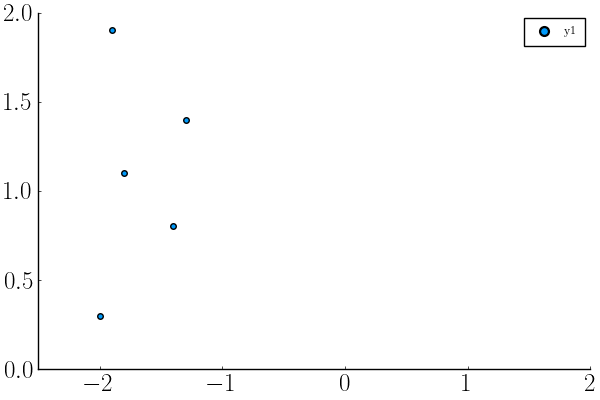

In [96]:
scatter(real.(zclusters)[1:Nclusters], imag.(zclusters)[1:Nclusters], xlims = (-2.5, 2.0), ylims = (0, 2.0))

In [97]:
freestream = Freestream(config_data.U)

Nv = Nclusters*Nset
zv = zeros(ComplexF64, Nv)

for i=1:Nclusters
    for j=1:Nset
#         @show (σr/2 + σr/2*clamp(randn(), -3.0, 3.0)/3.0)
        zv[(i-1)*Nset+j] = zclusters[i] + (σr/2 + σr/2*clamp(randn(), -3.0, 3.0)/3.0)*exp(im*2*π*rand())
    end
end

# zv =  rand(Nv) + 0.8*im*maximum(imag.(config_data.zs))*rand(Nv)
# zv .+= -2.0 + 0.1*im*maximum(imag.(config_data.zs))
Γv = zeros(Nv)
signclusters = [1; 1; 1; 1; 1; 1 ; 1]
Γvmean = [   0.09598711763757772;
             0.3942554457161529;
             0.66223264972610867;
             0.9718197621333651;
             0.7859171016908615;
             0.447930780784646;
             0.5103719570003264]
for i=1:Nclusters
    for j=1:Nset
        Γv[(i-1)*Nset+j] = signclusters[i]*abs.((0.4 + 0.1*randn()))
#         Γv[(i-1)*Nset+j] = signclusters[i]*abs.((Γvmean[i] + 0.1*randn()))
    end
#         Γv[i*Nset] = signclusters[i]*abs.(1.3 + 0.2*randn())
end
# Γv = abs.(randn(Nv))

blobs₊ = Nv >0 ? map(Vortex.Blob, zv, Γv, config_data.δ*ones(Nv)) : Vortex.Blob{Float64, Float64}[]
blobs₋ = Nv >0 ? map(Vortex.Blob, conj.(zv), -Γv, config_data.δ*ones(Nv)) : Vortex.Blob{Float64, Float64}[]

sys = (blobs₊, blobs₋)

data = generate_data_twin_experiment(deepcopy(sys), t0, tf, config_data, "/media/mat/HDD/LowRankVortex.jl/localization/");
tt, x0, xt, yt = load("/media/mat/HDD/LowRankVortex.jl/localization/data_twin_experiment.jld", "tt", "x0", "xt", "yt")
data = SyntheticData(tt, config_data.Δt, x0, xt, yt)

SyntheticData([0.0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009000000000000001  …  11.991, 11.992, 11.993, 11.994, 11.995000000000001, 11.996, 11.997, 11.998000000000001, 11.999, 12.0], 0.001, [-2.0535610260060895, 0.28671478829115504, 0.5288224694031529, -1.95210421577556, 1.9164626913954637, 0.34607043438493384, -1.829805350127954, 1.089392310844875, 0.33061329616652924, -1.2782629412361646, 1.357175096307226, 0.4040680457110529, -1.3511907987729546, 0.7609990493626337, 0.46385374791295136], [-2.0535250412149124 -2.052205126614951 … 12.997672478299997 12.998814986546156; 0.286722955687433 0.28667659484527075 … 1.157762541834807 1.1579501357631836; … ; 0.760935501710491 0.7611519490584697 … 0.9176894184303791 0.9177715344458863; 0.4639052333378007 0.4637837477851276 … 0.4719936627790357 0.472107878795163], [-0.5173551054115567 -0.5150816355880002 … -0.5140651325340314 -0.4871127100114925; -0.5523217541411625 -0.5445647801452491 … -0.5088755632923693 -0.49121162631439

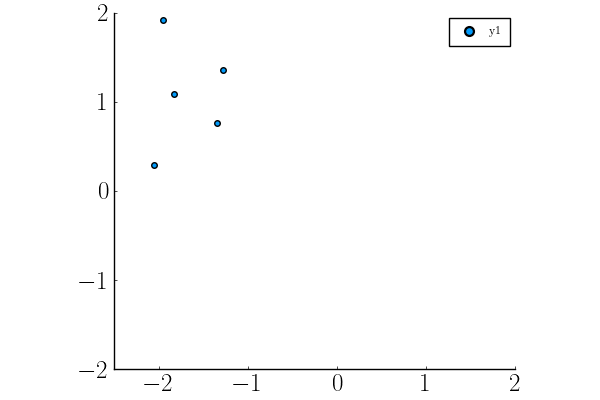

In [98]:
scatter(real.(zv), imag.(zv), xlims = (-2.5, 2.0), ylims = (-2.0, 2.0), ratio = 1.0)

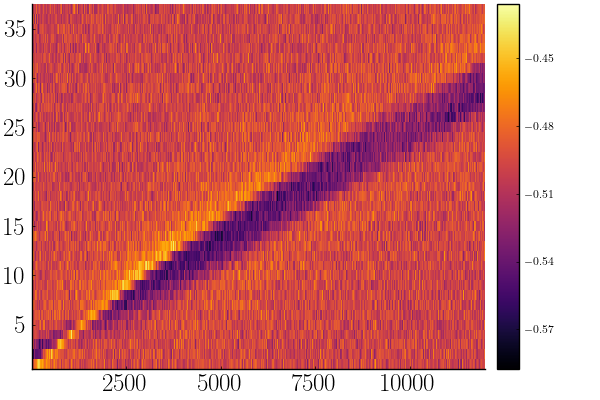

In [99]:
heatmap(data.yt)

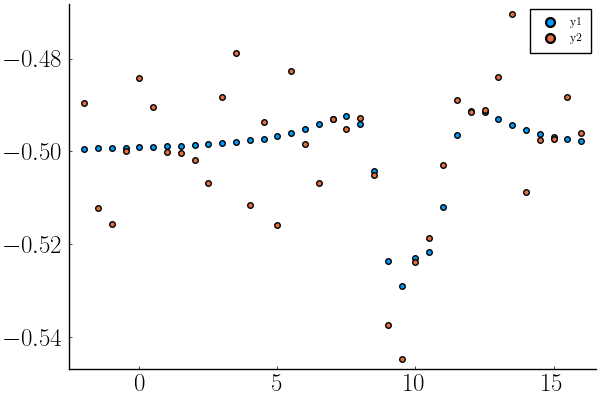

In [100]:
scatter(real.(config_data.ss), pressure(config_data.ss, state_to_lagrange(data.xt[:,10001], config_data), freestream, t0))
# scatter!(real.(config_data.ss), zeros(length(config_data.ss)))
scatter!(real.(config_data.ss), data.yt[:,10001])

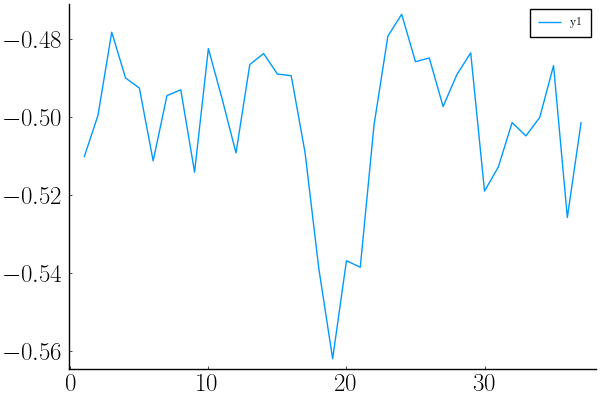

In [101]:
plot(data.yt[:,7501])

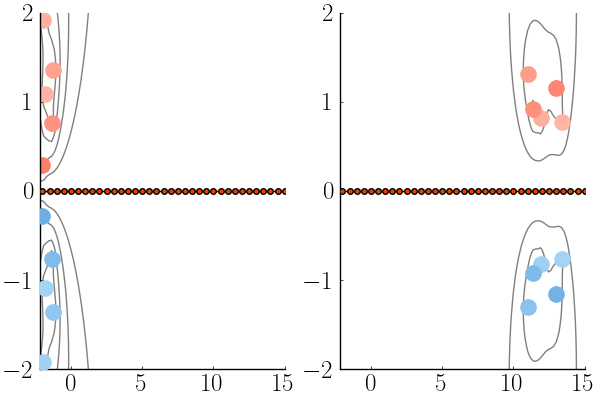

sys:1: UserWarning: The following kwargs were not used by contour: 'label'


In [102]:
plt1 = routine_plot(data.xt[:,1], config_data, xgrid, ygrid; withvortices = true)
plt2 = routine_plot(data.xt[:,end], config_data, xgrid, ygrid; withvortices = true)

plot(plt1, plt2)

### Setup the sequential filter

In [103]:
config = deepcopy(config_data)

VortexConfig(5, 1.0 + 0.0im, ComplexF64[-2.0 + 0.0im, -1.5 + 0.0im, -1.0 + 0.0im, -0.5 + 0.0im, 0.0 + 0.0im, 0.5 + 0.0im, 1.0 + 0.0im, 1.5 + 0.0im, 2.0 + 0.0im, 2.5 + 0.0im  …  11.5 + 0.0im, 12.0 + 0.0im, 12.5 + 0.0im, 13.0 + 0.0im, 13.5 + 0.0im, 14.0 + 0.0im, 14.5 + 0.0im, 15.0 + 0.0im, 15.5 + 0.0im, 16.0 + 0.0im], 0.001, 0.1, 0.0001, 0.0001, 1.0, 0.01)

In [104]:
ϵy = AdditiveInflation(Ny, zeros(Ny), config.ϵY)

AdditiveInflation(37, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0001 0.0 … 0.0 0.0; 0.0 0.0001 … 0.0 0.0; … ; 0.0 0.0 … 0.0001 0.0; 0.0 0.0 … 0.0 0.0001], [0.01 0.0 … 0.0 0.0; 0.0 0.01 … 0.0 0.0; … ; 0.0 0.0 … 0.01 0.0; 0.0 0.0 … 0.0 0.01])

In [105]:
senkf = StochEnKF(x-> x, ϵy, config.Δt, config.Δt; isfiltered = true)
lrenkf = LREnKF(x-> x, ϵy, config.Δt, config.Δt; isfiltered = true)

LREnKF  with filtered = true


In [106]:
# save("ensemble_Ne_"*string(Ne)*".jld", "Xf", Xf, "Xa", Xa)

In [128]:
# Generate the initial condition

Ne = 30
Nx = 3*config.Nv
Ny = length(config.ss)

X0 = zeros(Ny+Nx, Ne)

zv = zeros(ComplexF64, Nv)

for k=1:Ne
    for i=1:Nclusters
        for j=1:Nset
            zij = zclusters[i] + (σr/2 + σr/2*clamp(randn(), -3.0, 3.0)/3.0)*exp(im*2*π*rand())
            X0[Ny + (i-1)*Nset*3 + (j-1)*3 + 1, k] = real(zij)
            X0[Ny + (i-1)*Nset*3 + (j-1)*3 + 2, k] = imag(zij)
        end
    end
end

Γv = zeros(Nv)
signclusters = [1; 1; 1; 1; 1; 1 ; 1]

for k = 1:Ne
    for i=1:Nclusters
        for j=1:Nset
            Γij = signclusters[i]*abs.((0.4 + 0.1*randn()))
            X0[Ny + (i-1)*Nset*3 + (j-1)*3 + 3, k] = Γij
        end
    end
end

In [129]:
function dstateobs(X, Ny, Nx, config::VortexConfig)
    Nypx, Ne = size(X)
    @assert Nypx == Ny + Nx
    @assert Ny == length(config.ss)
    Nv = config.Nv
    dXY = zeros(Nv, Ny, Ne)
    
    for i=1:Ne
        xi = X[Ny+1:Ny+Nx, i]
        zi = map(l->xi[3*l-2] + im*xi[3*l-1], 1:Nv)

        for J=1:Nv
            for k=1:Ny
                dXY[J,k,i] = abs(zi[J] - config.ss[k])
            end
        end
    end
    return mean(dXY, dims = 3)[:,:,1]
end

# mean(map(i->abs(X0[Ny+1,i] + im * X0[Ny+2,i] - config.ss[1]), 1:Ne))-dstateobs(X0, Ny, Nx, config)[1,1]

dstateobs (generic function with 1 method)

In [130]:
function dobsobs(config::VortexConfig)
    Ny = length(config.ss) 
    dYY = zeros(Ny, Ny)
    for i=1:Ny
        for j=1:i-1
            dij = abs(config.ss[i] - config.ss[j])
            dYY[i,j] = dij
            dYY[j,i] = dij
        end
    end
    return dYY
end
# dobsobs(config)[1,end] - abs(config.ss[1]-config.ss[end])

dobsobs (generic function with 1 method)

In [131]:
dXY = dstateobs(X0, Ny, Nx, config)
dYY = dobsobs(config)

37×37 Matrix{Float64}:
  0.0   0.5   1.0   1.5   2.0   2.5  …  15.5  16.0  16.5  17.0  17.5  18.0
  0.5   0.0   0.5   1.0   1.5   2.0     15.0  15.5  16.0  16.5  17.0  17.5
  1.0   0.5   0.0   0.5   1.0   1.5     14.5  15.0  15.5  16.0  16.5  17.0
  1.5   1.0   0.5   0.0   0.5   1.0     14.0  14.5  15.0  15.5  16.0  16.5
  2.0   1.5   1.0   0.5   0.0   0.5     13.5  14.0  14.5  15.0  15.5  16.0
  2.5   2.0   1.5   1.0   0.5   0.0  …  13.0  13.5  14.0  14.5  15.0  15.5
  3.0   2.5   2.0   1.5   1.0   0.5     12.5  13.0  13.5  14.0  14.5  15.0
  3.5   3.0   2.5   2.0   1.5   1.0     12.0  12.5  13.0  13.5  14.0  14.5
  4.0   3.5   3.0   2.5   2.0   1.5     11.5  12.0  12.5  13.0  13.5  14.0
  4.5   4.0   3.5   3.0   2.5   2.0     11.0  11.5  12.0  12.5  13.0  13.5
  5.0   4.5   4.0   3.5   3.0   2.5  …  10.5  11.0  11.5  12.0  12.5  13.0
  5.5   5.0   4.5   4.0   3.5   3.0     10.0  10.5  11.0  11.5  12.0  12.5
  6.0   5.5   5.0   4.5   4.0   3.5      9.5  10.0  10.5  11.0  11.5  12.0
  

In [132]:
Lxy = 1.0
Lyy = 1.0

1.0

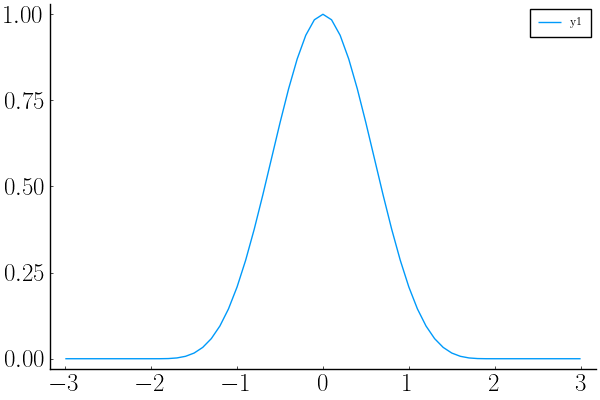

In [133]:
plot(-3.0:0.1:3.0, gaspari.(-3.0:0.1:3.0))

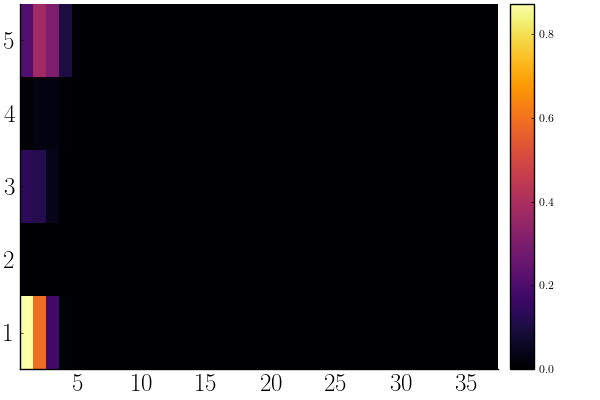

In [134]:
heatmap(gaspari.(dXY./Lxy))

In [135]:
function localized_senkf_symmetric_vortexassim(algo::StochEnKF, Lxy, Lyy, X, tspan::Tuple{S,S}, config::VortexConfig, data::SyntheticData; withfreestream::Bool = false, P::Parallel = serial) where {S<:Real}

    # Define the inflation parameters
    ϵX = config.ϵX
    ϵΓ = config.ϵΓ
    β = config.β
    ϵY = config.ϵY
    ϵx = RecipeInflation([ϵX; ϵΓ])
    ϵmul = MultiplicativeInflation(β)

    Ny = size(config.ss,1)

    # Set the time step between two assimilation steps
    Δtobs = algo.Δtobs
    # Set the time step for the time marching of the dynamical system
    Δtdyn = algo.Δtdyn
    t0, tf = tspan
    step = ceil(Int, Δtobs/Δtdyn)

    n0 = ceil(Int64, t0/Δtobs) + 1
    J = (tf-t0)/Δtobs
    Acycle = n0:n0+J-1

    # Array dimensions
    Nypx, Ne = size(X)
    Nx = Nypx - Ny
    ystar = zeros(Ny)

    # Cache variable for the velocities
    cachevels = allocate_velocity(state_to_lagrange(X[Ny+1:Ny+Nx,1], config))

    # Define the observation operator
    h(x, t) = measure_state_symmetric(x, t, config; withfreestream =  withfreestream)
    # Define an interpolation function in time and space of the true pressure field
    press_itp = CubicSplineInterpolation((LinRange(real(config.ss[1]), real(config.ss[end]), length(config.ss)),
                                   t0:data.Δt:tf), data.yt, extrapolation_bc =  Line())

    yt(t) = press_itp(real.(config.ss), t)
    Xf = Array{Float64,2}[]
    push!(Xf, copy(state(X, Ny, Nx)))

    Xa = Array{Float64,2}[]
    push!(Xa, copy(state(X, Ny, Nx)))

    dyy = dobsobs(config)
    Gyy = gaspari.(dyy./Lyy)

    # Run the ensemble filter
    for i=1:length(Acycle)

        # Forecast step
        @inbounds for j=1:step
            tj = t0+(i-1)*Δtobs+(j-1)*Δtdyn
            X, _ = symmetric_vortex(X, tj, Ny, Nx, cachevels, config; withfreestream = withfreestream)
        end

        push!(Xf, deepcopy(state(X, Ny, Nx)))

        # Get the true observation ystar
        ystar .= yt(t0+i*Δtobs)

        # Perform state inflation
        ϵmul(X, Ny+1, Ny+Nx)
        ϵx(X, Ny, Nx, config)

        # Filter state
        if algo.isfiltered == true
            @inbounds for i=1:Ne
                x = view(X, Ny+1:Ny+Nx, i)
                x .= filter_state!(x, config)
            end
        end

        # Evaluate the observation operator for the different ensemble members
        observe(h, X, t0+i*Δtobs, Ny, Nx; P = P)

        # Generate samples from the observation noise
        ϵ = algo.ϵy.σ*randn(Ny, Ne) .+ algo.ϵy.m

        # Form the perturbation matrix for the state
        Xpert = (1/sqrt(Ne-1))*(X[Ny+1:Ny+Nx,:] .- mean(X[Ny+1:Ny+Nx,:]; dims = 2)[:,1])
        # Form the perturbation matrix for the observation
        HXpert = (1/sqrt(Ne-1))*(X[1:Ny,:] .- mean(X[1:Ny,:]; dims = 2)[:,1])
        # Form the perturbation matrix for the observation noise
        ϵpert = (1/sqrt(Ne-1))*(ϵ .- mean(ϵ; dims = 2)[:,1])

        # Kenkf = Xpert*HXpert'*inv(HXpert*HXpert'+ϵpert*ϵpert')

        # Apply the Kalman gain based on the representers
        # Burgers G, Jan van Leeuwen P, Evensen G. 1998 Analysis scheme in the ensemble Kalman
        # filter. Monthly weather review 126, 1719–1724. Solve the linear system for b ∈ R^{Ny × Ne}:
        
        Σy = (HXpert*HXpert' + ϵpert*ϵpert')
        localizedΣy =  Gyy .* Σy
        # Apply localization 
        b = localizedΣy\(ystar .- (X[1:Ny,:] + ϵ))

        # Update the ensemble members according to:
        # x^{a,i} = x^i - Σ_{X,Y}b^i, with b^i =  Σ_Y^{-1}(h(x^i) + ϵ^i - ystar)
        dxy = dstateobs(X, Ny, Nx, config)
        Gxy = gaspari.(dxy./Lxy)
        localizedΣxy = (Xpert*HXpert')
        
        for J=1:config.Nv
            for i=-2:0
               localizedΣxy[3*J+i,:] .*= Gxy[J,:]
            end
        end
        view(X,Ny+1:Ny+Nx,:) .+= localizedΣxy*b

        # Filter state
        if algo.isfiltered == true
            @inbounds for i=1:Ne
                x = view(X, Ny+1:Ny+Nx, i)
                x .= filter_state!(x, config)
            end
        end

        push!(Xa, deepcopy(state(X, Ny, Nx)))
    end

    return Xf, Xa
end

localized_senkf_symmetric_vortexassim (generic function with 1 method)

In [136]:
@time Xf, Xa = senkf_symmetric_vortexassim(senkf, deepcopy(X0), tspan, config, data; withfreestream  = true, P = serial)
# save("ensemble_Ne_"*string(Ne)*"_2.jld", "Xf", Xf, "Xa", Xa)

rmse_enkf = mean(norm.(eachcol(mean_hist(Xa)-data.xt))[8000:end]/sqrt(size(data.x0,1)))

 13.763722 seconds (27.84 M allocations: 5.506 GiB, 7.54% gc time)


1.3599731033342789e11

In [137]:
@time Xf, Xa = localized_senkf_symmetric_vortexassim(senkf, Lxy, Lyy, deepcopy(X0), tspan, config, data; withfreestream  = true, P = serial)
# save("ensemble_Ne_"*string(Ne)*"_2.jld", "Xf", Xf, "Xa", Xa)

rmse_enkf = mean(norm.(eachcol(mean_hist(Xa)-data.xt))[8000:end]/sqrt(size(data.x0,1)))

 20.646504 seconds (30.51 M allocations: 6.522 GiB, 4.73% gc time, 3.14% compilation time)


0.10806858347476571

In [138]:
@time Xflowrank, Xalowrank, rxhist, ryhist = adaptive_lowrankenkf_symmetric_vortexassim(
                                                     lrenkf, 
                                                     deepcopy(X0), 
                                                     tspan, config, 
                                                     data; 
                                                     isadaptive = true,
                                                     withfreestream  = true, 
                                                     ratio = 0.99, P = serial)
# save("ensemble_lowrank_99_Ne_"*string(Ne)*"_2.jld", "Xf", Xflowrank, "Xa", Xalowrank, "rx", rxhist, "ry", ryhist)
rmse_lowrankenkf = mean(norm.(eachcol(mean_hist(Xalowrank)-data.xt))[8000:end]/sqrt(size(data.x0,1)))

 55.629673 seconds (73.10 M allocations: 43.356 GiB, 6.52% gc time)


0.03611970428091989